Found local copy...
Found local copy...
Found local copy...
These perturbations are not in the GO graph and their perturbation can thus not be predicted
['RHOXF2BB+ctrl' 'LYL1+IER5L' 'ctrl+IER5L' 'KIAA1804+ctrl' 'IER5L+ctrl'
 'RHOXF2BB+ZBTB25' 'RHOXF2BB+SET']
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:43
combo_seen2:19
unseen_single:36
Done!
Creating dataloaders....
Done!


here1


Found local copy...
Processing Genes: 100%|██████████████████████| 26/26 [4:48:37<00:00, 666.05s/it]


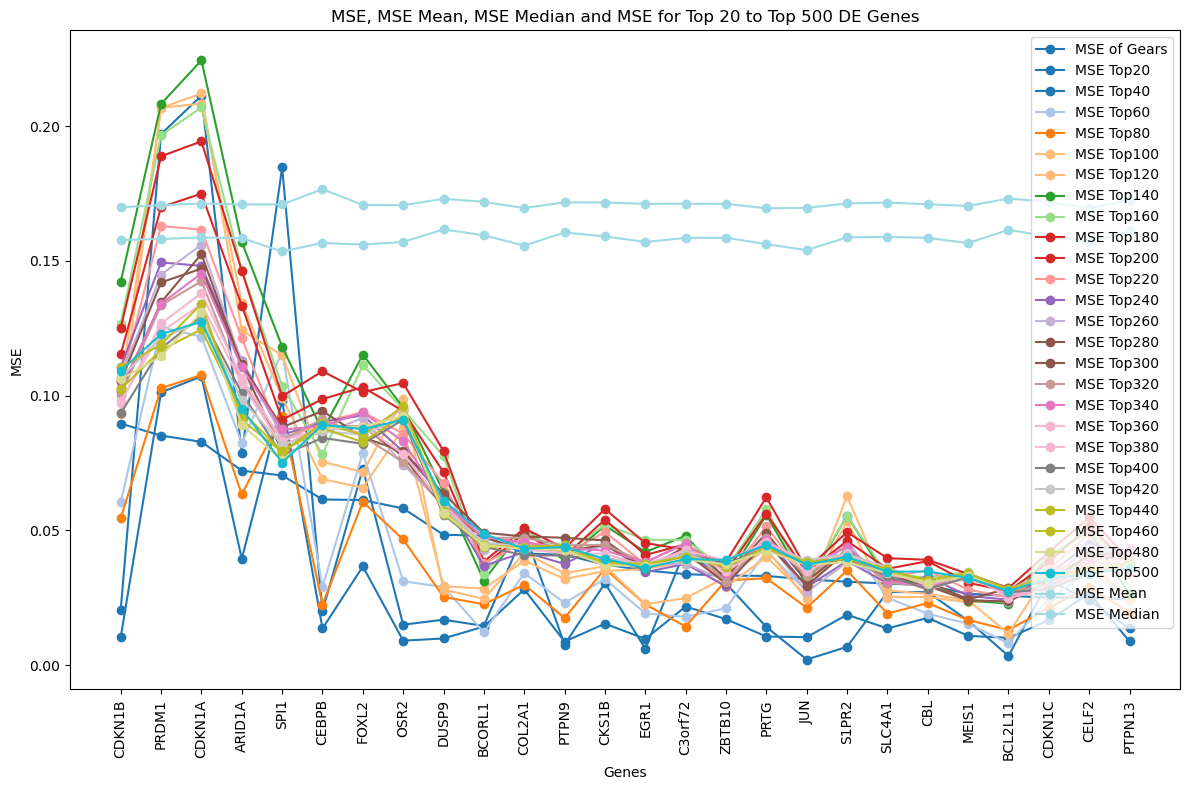

Gene: DUSP9
  MSE_Top20: 0.016835791990160942
  MSE_Top40: 0.00986692775040865
  MSE_Top60: 0.029021700844168663
  MSE_Top80: 0.02526714839041233
  MSE_Top100: 0.028008002787828445
  MSE_Top120: 0.02920236438512802
  MSE_Top140: 0.06424622237682343
  MSE_Top160: 0.07760243862867355
  MSE_Top180: 0.0794084444642067
  MSE_Top200: 0.07155299931764603
  MSE_Top220: 0.06740273535251617
  MSE_Top240: 0.06223108246922493
  MSE_Top260: 0.059292588382959366
  MSE_Top280: 0.058607570827007294
  MSE_Top300: 0.0636492520570755
  MSE_Top320: 0.0600060410797596
  MSE_Top340: 0.060409579426050186
  MSE_Top360: 0.059488534927368164
  MSE_Top380: 0.058051351457834244
  MSE_Top400: 0.055716972798109055
  MSE_Top420: 0.057683248072862625
  MSE_Top440: 0.05603167414665222
  MSE_Top460: 0.057265929877758026
  MSE_Top480: 0.056558798998594284
  MSE_Top500: 0.06100241839885712
  MSE_Mean: 0.16165116429328918
  MSE_Median: 0.17302106320858002
Gene: BCORL1
  MSE_Top20: 0.014513866975903511
  MSE_Top40: 0.01428

In [2]:
# %load /Users/f0052zm/Desktop/perturb/GEARS-master/slow.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from scipy.stats import ttest_ind
from gears import PertData, GEARS
from tqdm import tqdm

pert_data = PertData('./data')
pert_data.load(data_name='norman')
pert_data.prepare_split(split='simulation', seed=1)
pert_data.get_dataloader(batch_size=32, test_batch_size=128)
gears_model = GEARS(pert_data, device='mps')
gears_model.model_initialize(hidden_size=64)
gears_model.load_pretrained('benchmark_norman')

genes_to_predict = []
test_conditions = pert_data.set2conditions['test']

for condition in test_conditions:
    if '+ctrl' in condition:
        parts = condition.split('+')
        for part in parts:
            if part != 'ctrl':
                genes_to_predict.append(part)

gene_results = {}

for gene in tqdm(genes_to_predict, desc="Processing Genes"):
    key1 = f'{gene}+ctrl'
    key2 = f'ctrl+{gene}'

    predictions = gears_model.predict([[gene]])
    ctrl_condition_rows = pert_data.adata.obs['condition'].isin([key1, key2])

    if ctrl_condition_rows.sum() > 0:
        true_values = pert_data.adata[ctrl_condition_rows, :].X.toarray()[0]
        pred_values = predictions[gene]

        mse_value = mse(true_values, pred_values)
        mae_value = mae(true_values, pred_values)

        mean_true_values = np.mean(true_values)
        median_true_values = np.median(true_values)
        mse_mean = mse(np.full_like(true_values, mean_true_values), pred_values)
        mae_mean = mae(np.full_like(true_values, mean_true_values), pred_values)
        mse_median = mse(np.full_like(true_values, median_true_values), pred_values)
        mae_median = mae(np.full_like(true_values, median_true_values), pred_values)

        p_values = []
        for g in pert_data.adata.var_names:
            group1 = pert_data.adata[:, g].X[pert_data.adata.obs['condition'] == 'ctrl'].toarray()
            group2 = pert_data.adata[:, g].X[pert_data.adata.obs['condition'].isin([key1, key2])].toarray()
            if group2.size == 0:
                continue
            _, p = ttest_ind(group1, group2, equal_var=False)
            p_values.append((g, p))

        sorted_genes = sorted(p_values, key=lambda x: x[1])
        mse_top_values = {}
        for top_n in range(20, 501, 20):
            top_genes_names = [g for g, _ in sorted_genes[:top_n]]
            top_true_values = true_values[[pert_data.adata.var_names.get_loc(g) for g in top_genes_names]]
            top_pred_values = pred_values[[pert_data.adata.var_names.get_loc(g) for g in top_genes_names]]
            mse_top_values[f'MSE_Top{top_n}'] = mse(top_true_values, top_pred_values)

        gene_results[gene] = {
            'MSE': mse_value,
            'MAE': mae_value,
            'MSE_Mean': mse_mean,
            'MAE_Mean': mae_mean,
            'MSE_Median': mse_median,
            'MAE_Median': mae_median,
        }
        gene_results[gene].update(mse_top_values)

metrics_df = pd.DataFrame.from_dict(gene_results, orient='index')
metrics_df = metrics_df.sort_values(by='MSE', ascending=False)

plt.figure(figsize=(12, 8))
plt.plot(metrics_df.index, metrics_df['MSE'], marker='o', label='MSE of Gears')

colors = plt.cm.get_cmap('tab20', len(range(20, 501, 20)) + 2)

for i, top_n in enumerate(range(20, 501, 20)):
    plt.plot(metrics_df.index, metrics_df[f'MSE_Top{top_n}'], marker='o', label=f'MSE Top{top_n}', color=colors(i))

plt.plot(metrics_df.index, metrics_df['MSE_Mean'], marker='o', label='MSE Mean', color=colors(len(range(20, 501, 20))))
plt.plot(metrics_df.index, metrics_df['MSE_Median'], marker='o', label='MSE Median', color=colors(len(range(20, 501, 20)) + 1))

plt.xlabel('Genes')
plt.ylabel('MSE')
plt.title('MSE, MSE Mean, MSE Median for Top 20 to Top 500 DE Genes')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

for gene, result in gene_results.items():
    print(f"Gene: {gene}")
    for top_n in range(20, 501, 20):
        print(f"  MSE_Top{top_n}: {result[f'MSE_Top{top_n}']}")
    print(f"  MSE_Mean: {result['MSE_Mean']}")
    print(f"  MSE_Median: {result['MSE_Median']}")